# Importing the data

First, we will start by importing the `Post` objects that store our scraped data. For the purpose of this tutorial, the scraped data has already been serialized in a Python `shelve` database for easy access so let's load those into memory for analysis

In [2]:
import shelve

from pandas import DataFrame

with shelve.open("trump_posts.db") as db:
    posts = db['post_data']

# Preprocessing our data 

Now that the data is imported, let's start preprocessing it for analysis by instantiating a `pandas.DataFrame`. instascrape is designed in such a way that it can be easily integrated with `pandas` for powerful analysis in an expressive, tabular format. 

In [43]:
import pandas as pd

df = pd.DataFrame([post.to_dict() for post in posts])

Now that we have our data in a `pandas.DataFrame`, let's prepare it to be fitted with a `scikit.linear_model.LinearRegression`. We will start by using `sklearn.preprocessing.StandardScaler` to scale our data into an appropriate range. 

In [44]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()      
sc_y = StandardScaler()

# Convert a 1D numpy array into a 2D column-like array. 
def two_dimensionalize(arr): return arr.reshape((len(arr), 1))

# StandardScaler.fit_transform expects a 2D-array. 
x_dt = df['timestamp'].to_numpy()
x_dt = two_dimensionalize(x_dt)
y_dt = df['likes'].to_numpy()
y_dt = two_dimensionalize(y_dt)

# Feature scaling to get data on same scale.
x_transform = sc_x.fit_transform(x_dt)
y_transform = sc_y.fit_transform(y_dt)

Now that our data is scaled appropriately, we are going to create a new feature matrix with data prepared for a polynomial regression. To do so, we will transform our data with `sklearn.preprocessing.PolynomialFeatures`

In [45]:
from sklearn.preprocessing import PolynomialFeatures

#Further scaling for IV.
polyreg = PolynomialFeatures(degree=4)
x_poly = polyreg.fit_transform(x_transform)

# Fitting the polynomial regressor

Now that our data has been preprocessed and we have an appropriate feature matrix for fitting a polynomial regression, we will fit our data and get a set of dependant variables predicted by the regressor. 

In this case, we will use these values to plot a curve fit to show underlying trends in a scatter plot. 

In [46]:
from sklearn.linear_model import LinearRegression
import numpy as np

#Create and fit polynomial regression. 
regressor = LinearRegression()
regressor.fit(x_poly, y_transform)

#Calculate predictions from the model for every independant variable data point.  
y_predict = np.array([regressor.predict([val]) for val in x_poly])
y_predict = two_dimensionalize(y_predict)
y_final = sc_y.inverse_transform(y_predict)
y_final = y_final.flatten()

# Visualizing our data

Now with our data and polynomial regression, we can create a scatter plot to visualize user engagement over the last few months.

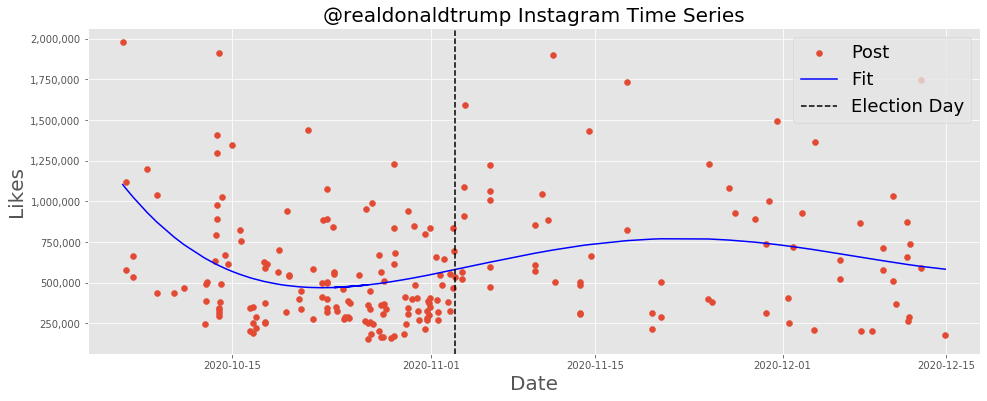

In [47]:
import datetime

import matplotlib.pyplot as plt
import matplotlib

# Create plot and style. 
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(16,6))

# Draw scatter plot.
upload_date = df["upload_date"].to_numpy()
likes = df["likes"].to_numpy()
ax.scatter(upload_date, likes, label="Post")

# Draw polynomial regression.
ax.plot(upload_date, y_final, label='Fit', color="blue")

# Draw Election Day vertical line. 
election_date = datetime.date(2020, 11,3)
ax.axvline(election_date, linestyle='--', label="Election Day", color="black")

# Set plot x-bounds. 
left_xlim=df["upload_date"].min()-datetime.timedelta(days=3)
right_xlim=df["upload_date"].max()+datetime.timedelta(days=3)
ax.set_xlim(left=left_xlim, right=right_xlim)

# Draw labels on plot. 
ax.set_title("@realdonaldtrump Instagram Time Series", fontsize=20)
ax.set_xlabel("Date", fontsize=20)
ax.set_ylabel("Likes", fontsize=20)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Format and draw plot legend.
handles,labels = ax.get_legend_handles_labels()
handles = [handles[2], handles[0], handles[1]]
labels = [labels[2], labels[0], labels[1]]
ax.legend(handles,labels, loc=1, fontsize=18)

In [156]:
df["location"][df["location"].notna()]

0                                 Information icon.
1            West Point - The U.S. Military Academy
2                                   The White House
3                                 Information icon.
4                                 Information icon.
                           ...                     
194                               Information icon.
203                                 The White House
204                                 The White House
205                                 The White House
207    Walter Reed National Military Medical Center
Name: location, Length: 171, dtype: object